In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from collections import deque
import cv2
import gym
from gym import Wrapper
from gym import ObservationWrapper
import numpy as np
import matplotlib.pyplot as plt
from time import time


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
ENV_NAME = 'BreakoutNoFrameskip-v4'

env = gym.make(ENV_NAME)

(210, 160, 3)


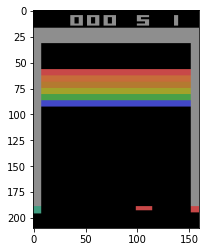

In [3]:
state = env.reset()

print(state.shape)
plt.imshow(state)
plt.show()

In [4]:
class NoopResetEnv(Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        super().__init__(env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

In [5]:
class MaxAndSkipEnv(Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(self._obs_buffer, axis=0)

        return max_frame, total_reward, done, info

In [6]:
class EpisodicLifeEnv(Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        super().__init__(env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

In [7]:
class FireResetEnv(Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        super().__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

In [8]:
class WarpFrame(ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs

(84, 84, 1)


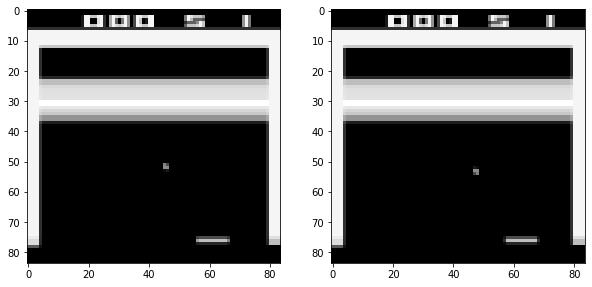

In [9]:
def make_atari(name):
    env = gym.make(ENV_NAME)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    return env


env = make_atari(ENV_NAME)
state = env.reset()
print(state.shape)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(state[:, :, 0], cmap='gray')

state, _, _, _ = env.step(env.action_space.sample())

plt.subplot(1, 2, 2)
plt.imshow(state[:, :, 0], cmap='gray')

plt.show()

In [10]:
test_env = make_atari(ENV_NAME)

In [11]:
class ReplayBuffer(object):
    """
    states, action, reward, done will be store as
    s0, s1, s2, s3, ......, sn-1, sn
    a0, a1, a2, a3, ......, an-1, 0
    r0, r1, r2, r3, ......, rn-1, 0
    d0, d1, d2, d3, ......, True, False,
    True, b1, b2, b3, ...., False, False
    
    where sn is the end state
    d0, d1, d2, ... dn-2, are all False
    b1, b2, b3, ... bn, are all False
    """
    def __init__(self, buffer_size, history_size, state_shape=[], dtype=np.uint8):
        self.buffer_size = buffer_size
        self.history_size = history_size
        self.current_index = 0
        self.current_size = 0
        self.end = True
        self.memory = np.zeros(shape=[buffer_size] + state_shape, dtype=dtype)
        self.action = np.zeros(shape=[buffer_size], dtype=np.int32)
        self.reward = np.zeros(shape=[buffer_size], dtype=np.float32)
        self.done = np.zeros(shape=[buffer_size], dtype=np.bool)
        self.begin = np.zeros(shape=[buffer_size], dtype=np.bool)
    
    def add(self, state, action, reward, next_state, done):
        idx = self.current_index
        self.memory[idx, ...] = state[:, :, 0]
        self.action[idx] = action
        self.reward[idx] = reward
        self.done[idx] = done
        self.current_index = (self.current_index + 1) % self.buffer_size
        self.current_size = min(self.current_size+1, self.buffer_size)
        if self.end:
            self.begin[idx] = True
            self.end = False
        else:
            self.begin[idx] = False
        
        if done:
            self.end = True
            self.add(next_state, 0, 0, next_state, False)
            
    def get_slice(self, index):
        if index < self.history_size - 1:
            states = np.concatenate([self.memory[index-self.history_size+1:, ...],
                                     self.memory[:index+2, ...]], axis=0)
            action = self.action[index]
            reward = self.reward[index]
            done = self.done[index]
        else:
            states = self.memory[index-self.history_size+1:index+2, ...]
            action = self.action[index]
            reward = self.reward[index]
            done = self.done[index]
        
        states = np.copy(states)
        
        # fill with first frame when found last episode
        prev = False
        frame = self.memory[index]
        for i in range(index-1, index-self.history_size, -1):
            prev = prev or self.done[i-1] or self.begin[i+1]
            if prev:
                # print(i - index + self.history_size - 1)
                states[i - index + self.history_size - 1] = frame
            else:
                frame = self.memory[i]
        
        states = np.transpose(states, [1, 2, 0])
        return states, action, reward, done
            
    def get_step(self, index):
        states, action, reward, done = self.get_slice(index)
        next_states = states[:, :, 1:]
        states = states[:, :, :-1]
        return states, action, reward, done, next_states
    
    def sample_index(self):
        index = np.random.randint(0, self.current_size-2)
        while self.done[index-1] or self.begin[index+1]:
            index = np.random.randint(0, self.current_size-2)
        return index
    
    def sample(self, pos_prob):
        index = self.sample_index()
        
        # p = np.random.uniform()
        # if p < pos_prob:
        #     while self.reward[index] == 0:
        #         index = self.sample_index()
        return self.get_step(index)
    
    def next_batch(self, batch_size, pos_prob=0.2):
        assert self.current_size > 1
        
        batch_states = []
        batch_next_states = []
        batch_action = []
        batch_reward = []
        batch_done = []
        for _ in range(batch_size):
            states, action, reward, done, next_states = self.sample(pos_prob)
            batch_states.append(states)
            batch_action.append(action)
            batch_reward.append(reward)
            batch_done.append(done)
            batch_next_states.append(next_states)
        batch_states = np.array(batch_states)
        batch_action = np.array(batch_action)
        batch_reward = np.array(batch_reward)
        batch_done = np.array(batch_done)
        batch_next_states = np.array(batch_next_states)
        return batch_states, batch_action, batch_reward, batch_done, batch_next_states


HISTORY_SIZE = 4
INPUT_SIZE = [84, 84]
replay_buffer = ReplayBuffer(60, HISTORY_SIZE, state_shape=INPUT_SIZE)

env = make_atari(ENV_NAME)
for episode in range(1):
    state = env.reset()
    while True:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        if done:
            break

state = env.reset()
next_state, reward, done, _ = env.step(action)
replay_buffer.add(state, action, reward, next_state, done)

print(replay_buffer.done)
print(replay_buffer.begin)
print(replay_buffer.reward)
print('current_size: ', replay_buffer.current_size)

[False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[ True False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
current_size:  25


step:  0
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  3
step:  1
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  2
step:  2
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  1
step:  3
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  3


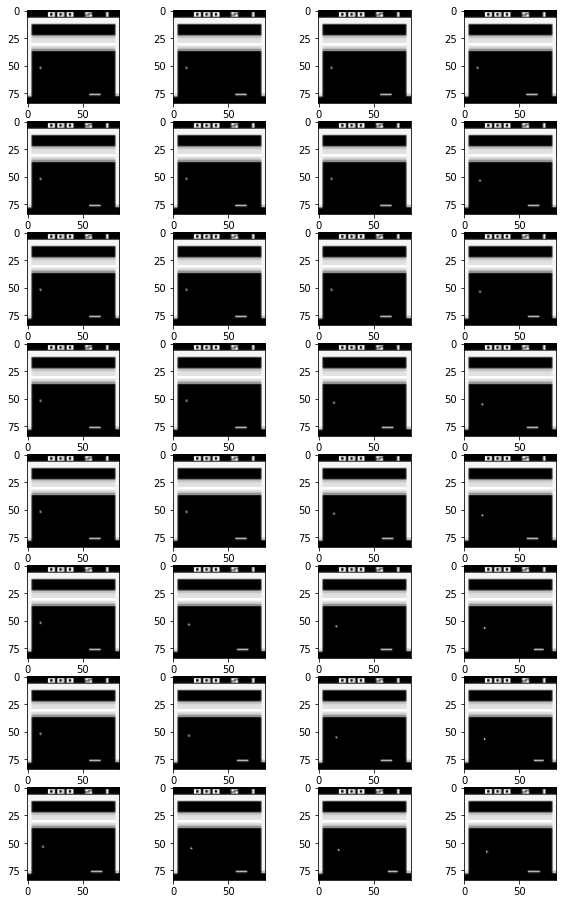

In [12]:
def sample_replay_buffer(offset=0):
    plt.figure(figsize=(10, 16))
    for i in range(4):
        state, action, reward, done, next_state = replay_buffer.get_step(offset+i)
        print('step: ', offset+i)
        print('state: ', state.shape)
        print('next_state:', next_state.shape)
        print('action: ', action)

        # for k in range(4-i):
        #     assert np.all(state[:, :, 0] == state[:, :, k])

        for j in range(HISTORY_SIZE):
            plt.subplot(HISTORY_SIZE * 2, HISTORY_SIZE, 2 * i * HISTORY_SIZE + j + 1)
            plt.imshow(state[:, :, j], cmap='gray')

            plt.subplot(HISTORY_SIZE * 2, HISTORY_SIZE, 2 * i * HISTORY_SIZE + HISTORY_SIZE + j + 1)
            plt.imshow(next_state[:, :, j], cmap='gray')

    plt.show()


sample_replay_buffer()

step:  17
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  0
step:  18
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  0
step:  19
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  2
step:  20
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  2


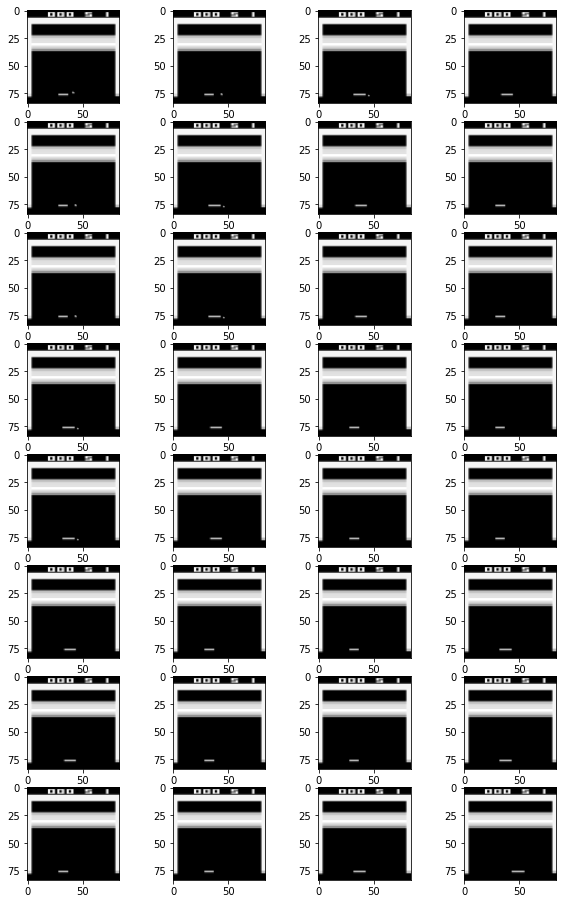

In [13]:
sample_replay_buffer(17)

step:  21
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  3
step:  22
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  1
step:  23
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  0
step:  24
state:  (84, 84, 4)
next_state: (84, 84, 4)
action:  1


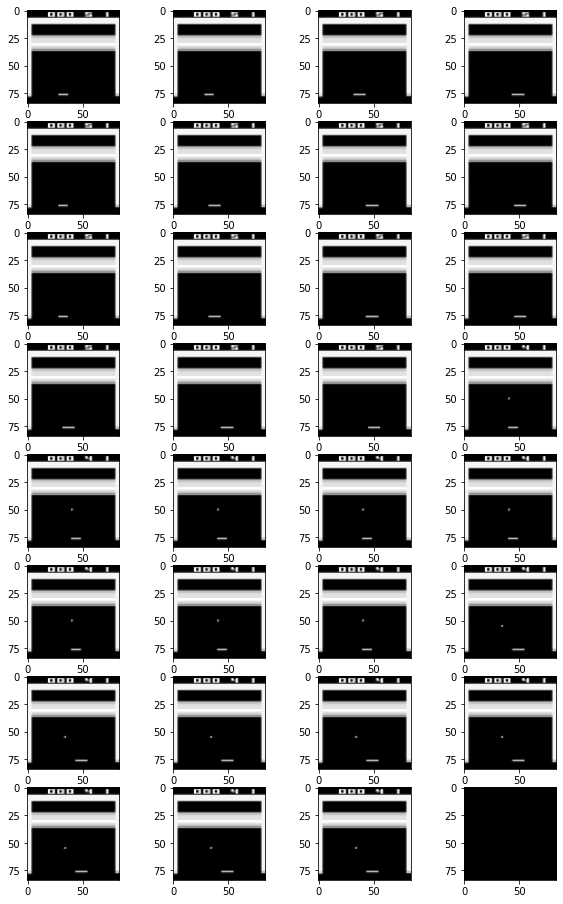

In [14]:
sample_replay_buffer(21)

In [15]:
def collect_episode(policy):
    state = env.reset()
    step = 0
    while True:
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        step += 1
        if done:
            break

def random_policy(_):
    return env.action_space.sample()


def initial_collect(init_size):
    env = make_atari(ENV_NAME)
    while replay_buffer.current_size < init_size:
        collect_episode(random_policy)
        print('\rcurrent size: ', replay_buffer.current_size, end='')
    print()


REPLAY_BUFFER_SIZE = 1000000
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE, HISTORY_SIZE,
                             state_shape=[INPUT_SIZE[0], INPUT_SIZE[1]])

REPLAY_BUFFER_INIT_SIZE = 60000
initial_collect(REPLAY_BUFFER_INIT_SIZE)

assert np.sum(replay_buffer.reward) > 0

current size:  60028


In [16]:
def build_model(num_actions):
    return keras.Sequential([
        keras.layers.Conv2D(32, 8, 4, padding='same', activation='relu',
                            input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], HISTORY_SIZE]),
        keras.layers.Conv2D(64, 4, 2, padding='same', activation='relu'),
        keras.layers.Conv2D(64, 3, 1, padding='same', activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(num_actions)
    ])


NUM_ACTIONS = env.action_space.n
keras.backend.clear_session()
Q = build_model(NUM_ACTIONS)
Q.summary()

target_Q = build_model(NUM_ACTIONS)
# optimizer = keras.optimizers.RMSprop(2.5e-4, rho=0.95, momentum=0.95, epsilon=0.01)
optimizer = keras.optimizers.Adam(1.26e-5, decay=0.0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3965440   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 4,045,476
Trainable params: 4,045,476
Non-trainable params: 0
______________________________________________

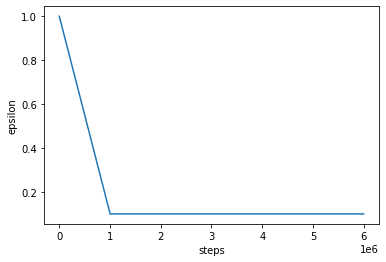

In [17]:
class EpsilonGreedyPolicy(object):
    def __init__(self, decay_duration, min_eps=0.1):
        self.decay_duration = decay_duration
        self.min_eps = min_eps
        self.eps = self.compute_eps(0)
        
    def compute_eps(self, step):
        return (1.0 - self.min_eps) * np.maximum(self.decay_duration - step, 0) / self.decay_duration + self.min_eps

    def update(self, step):
        self.eps = self.compute_eps(step)
    
    def __call__(self, state):
        if np.random.uniform() < self.eps:
            return env.action_space.sample()
        else:
            s = tf.cast(state[tf.newaxis], tf.float32) / 255.0
            q = Q(s, training=False)
            action = tf.argmax(q[0]).numpy()
            return action


epsilon_greedy = EpsilonGreedyPolicy(1000000)
steps = np.arange(6000000)
eps = epsilon_greedy.compute_eps(steps)

plt.plot(steps, eps)
plt.xlabel('steps')
plt.ylabel('epsilon')
plt.show()

In [18]:
def eval_reward(policy, num_episodes=10):
    R = []
    for episode in range(num_episodes):
        state = test_env.reset()
        buffer = deque(maxlen=HISTORY_SIZE)
        for _ in range(HISTORY_SIZE):
            buffer.append(state[:, :, 0])
        # buffer.append(state[:, :, 0])
        
        total_reward = 0
        while True:
            state_buf = np.stack(buffer, axis=-1)
            action = policy(state_buf)
            next_state, reward, done, _ = test_env.step(action)
            total_reward += reward
            state = next_state
            buffer.append(state[:, :, 0])
            if done:
                break
        R.append(total_reward)
    return np.mean(R), np.min(R), np.max(R)


R = eval_reward(epsilon_greedy)
print(R)

(0.3, 0.0, 2.0)


In [19]:
GAMMA = 0.99

@tf.function
def train_step(states, actions, rewards, done, next_states):
    with tf.GradientTape() as tape:
        states = tf.cast(states, tf.float32) / 255.0
        next_states = tf.cast(next_states, tf.float32) / 255.0
        r = tf.clip_by_value(rewards, -1.0, 1.0)
        not_done = tf.cast(tf.logical_not(done), tf.float32)
        q_primes = target_Q(next_states, training=False)
        
        max_a = tf.one_hot(tf.argmax(Q(next_states), axis=1), env.action_space.n)
        max_a = tf.stop_gradient(max_a)
        target_q = tf.reduce_sum(q_primes * max_a, axis=1)
        # y = r + GAMMA * not_done * tf.reduce_max(q_primes, axis=1)
        y = r + GAMMA * not_done * target_q
        
        q_values = Q(states)
        mask = tf.one_hot(actions, env.action_space.n)
        x = tf.reduce_sum(mask * q_values, axis=1)
        huber = keras.losses.Huber()(y, x)
        
    grad = tape.gradient(huber, Q.trainable_variables)
    optimizer.apply_gradients(zip(grad, Q.trainable_variables))
    return huber, tf.reduce_max(q_values)



BATCH_SIZE = 32
states, actions, rewards, done, next_states = replay_buffer.next_batch(BATCH_SIZE)
loss, max_q, = train_step(states, actions, rewards, done, next_states)
print('loss: ', loss)
print('max q: ', max_q)

loss:  tf.Tensor(0.043608002, shape=(), dtype=float32)
max q:  tf.Tensor(0.10281944, shape=(), dtype=float32)


In [20]:
def learning_rate_schedule(step):
    if step < 1000000:
        return 2.5e-4
    elif step <= 2000000:
        return 1e-4
    return 5e-5


def run(starting_step=0, max_steps=10000000, update_interval=10000, train_interval=4):
    checkpoint = tf.train.Checkpoint()
    checkpoint_path = '../checkpoint/atari/%s.checkpoint' % (ENV_NAME)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=3)
    
    step = starting_step
    while step < max_steps:
        # begin episode
        state = env.reset()
        # prepare state buffer for inference
        # because the model needs HISTORY_SIZE=4 states to stack up
        buffer = deque(maxlen=HISTORY_SIZE)
        for _ in range(HISTORY_SIZE):
            buffer.append(state[:, :, 0])
        # buffer.append(state[:, :, 0])
        
        # run this episode
        losses = []
        max_qs = []
        while True:
            epsilon_greedy.update(step)
            state_buf = np.stack(np.array(buffer), axis=-1)
            # execute policy
            action = epsilon_greedy(state_buf)
            next_state, reward, done, _ = env.step(action)
            # collect data
            replay_buffer.add(state, action, reward, next_state, done)
            
            # training section
            # update weights
            if step % update_interval == 0:
                target_Q.set_weights(Q.get_weights())
            
            if step % train_interval == 0:
                states, actions, rewards, dones, next_states = replay_buffer.next_batch(BATCH_SIZE)
                loss, max_q = train_step(states, actions, rewards, dones, next_states)
                losses.append(loss.numpy())
                max_qs.append(max_q.numpy())
                print('\r%d. loss: %f, max Q: %f' % (step, np.mean(losses), np.mean(max_qs)), end='')
            
            if step % update_interval == 0 and step > 0:
                losses = []
                max_qs = []
                R = eval_reward(epsilon_greedy)
                start_time = time()
                # optimizer.learning_rate = learning_rate_schedule(step)
                print()
                print('mean: ', R[0], 'min: ', R[1], 'max: ', R[2])
                # print('rewards: ', R, ' --- new learning rate: ', optimizer.learning_rate.numpy())

            if step % (update_interval * 50) == 0 and step > 0:
                print('saving model...')
                manager.save()
            # end training section
            
            # continue next step
            step += 1
            state = next_state
            buffer.append(state[:, :, 0])
            if done:
                break


run()

10000. loss: 0.006908, max Q: 0.098177
mean:  0.6 min:  0.0 max:  2.0
20000. loss: 0.004547, max Q: 0.279959
mean:  0.0 min:  0.0 max:  0.0
30000. loss: 0.001393, max Q: 0.324350
mean:  0.3 min:  0.0 max:  1.0
40000. loss: 0.003944, max Q: 0.487611
mean:  0.4 min:  0.0 max:  2.0
50000. loss: 0.007659, max Q: 1.229183
mean:  0.1 min:  0.0 max:  1.0
60000. loss: 0.005826, max Q: 0.850954
mean:  0.2 min:  0.0 max:  1.0
70000. loss: 0.002541, max Q: 0.971499
mean:  0.1 min:  0.0 max:  1.0
80000. loss: 0.001679, max Q: 1.033758
mean:  0.2 min:  0.0 max:  2.0
90000. loss: 0.000977, max Q: 1.043247
mean:  0.4 min:  0.0 max:  2.0
100000. loss: 0.000509, max Q: 1.113527
mean:  0.5 min:  0.0 max:  2.0
110000. loss: 0.000992, max Q: 1.332185
mean:  0.2 min:  0.0 max:  1.0
120000. loss: 0.003099, max Q: 1.317278
mean:  0.1 min:  0.0 max:  1.0
130000. loss: 0.001407, max Q: 1.177562
mean:  0.1 min:  0.0 max:  1.0
140000. loss: 0.001185, max Q: 1.275228
mean:  0.0 min:  0.0 max:  0.0
150000. loss: 0

1150000. loss: 0.002335, max Q: 2.457789
mean:  10.9 min:  0.0 max:  34.0
1160000. loss: 0.002816, max Q: 2.471926
mean:  8.9 min:  1.0 max:  34.0
1170000. loss: 0.002380, max Q: 2.441763
mean:  8.6 min:  3.0 max:  15.0
1180000. loss: 0.001270, max Q: 2.502153
mean:  10.7 min:  1.0 max:  33.0
1190000. loss: 0.002011, max Q: 2.507587
mean:  4.3 min:  0.0 max:  8.0
1200000. loss: 0.002780, max Q: 2.530862
mean:  5.6 min:  0.0 max:  13.0
1210000. loss: 0.002360, max Q: 2.526736
mean:  11.8 min:  3.0 max:  28.0
1220000. loss: 0.002565, max Q: 2.544136
mean:  9.5 min:  0.0 max:  19.0
1230000. loss: 0.001569, max Q: 2.573208
mean:  8.6 min:  0.0 max:  17.0
1240000. loss: 0.002824, max Q: 2.549018
mean:  10.9 min:  4.0 max:  28.0
1250000. loss: 0.002501, max Q: 2.557287
mean:  10.4 min:  0.0 max:  18.0
1260000. loss: 0.002025, max Q: 2.592305
mean:  7.4 min:  0.0 max:  18.0
1270000. loss: 0.001612, max Q: 2.588713
mean:  8.2 min:  0.0 max:  19.0
1280000. loss: 0.002223, max Q: 2.591187
mean: 

2250000. loss: 0.005630, max Q: 5.2944208
mean:  11.6 min:  0.0 max:  34.0
2260000. loss: 0.004291, max Q: 4.3178830
mean:  13.4 min:  4.0 max:  56.0
2270000. loss: 0.005309, max Q: 4.8028251
mean:  17.2 min:  4.0 max:  42.0
2280000. loss: 0.003352, max Q: 4.2854304
mean:  16.1 min:  4.0 max:  35.0
2290000. loss: 0.002827, max Q: 4.3177616
mean:  11.4 min:  0.0 max:  23.0
2300000. loss: 0.014182, max Q: 6.1289334
mean:  18.6 min:  1.0 max:  48.0
2310000. loss: 0.002827, max Q: 3.7827943
mean:  20.4 min:  2.0 max:  70.0
2320000. loss: 0.004482, max Q: 4.3314710
mean:  15.6 min:  3.0 max:  32.0
2330000. loss: 0.006452, max Q: 6.5407773
mean:  14.8 min:  0.0 max:  48.0
2340000. loss: 0.003376, max Q: 4.7942095
mean:  10.1 min:  0.0 max:  28.0
2350000. loss: 0.004457, max Q: 5.1120442
mean:  15.4 min:  0.0 max:  43.0
2360000. loss: 0.002725, max Q: 5.2785442
mean:  19.3 min:  4.0 max:  51.0
2370000. loss: 0.004798, max Q: 4.8753722
mean:  14.2 min:  1.0 max:  54.0
2380000. loss: 0.002379, 

3340000. loss: 0.006864, max Q: 9.6237323
mean:  8.6 min:  0.0 max:  36.0
3350000. loss: 0.007783, max Q: 12.044574
mean:  32.1 min:  0.0 max:  157.0
3360000. loss: 0.005932, max Q: 9.0859235
mean:  30.3 min:  0.0 max:  174.0
3370000. loss: 0.005503, max Q: 9.0160037
mean:  11.9 min:  2.0 max:  29.0
3380000. loss: 0.008287, max Q: 8.9123397
mean:  18.6 min:  0.0 max:  43.0
3390000. loss: 0.007348, max Q: 9.1435626
mean:  15.6 min:  0.0 max:  68.0
3400000. loss: 0.009578, max Q: 10.188426
mean:  8.6 min:  0.0 max:  22.0
3410000. loss: 0.006626, max Q: 8.4743271
mean:  13.0 min:  0.0 max:  25.0
3420000. loss: 0.008212, max Q: 9.1035604
mean:  16.9 min:  0.0 max:  71.0
3430000. loss: 0.009764, max Q: 9.2785411
mean:  33.6 min:  0.0 max:  249.0
3440000. loss: 0.006626, max Q: 9.6967877
mean:  15.5 min:  0.0 max:  31.0
3450000. loss: 0.009361, max Q: 10.153522
mean:  12.4 min:  0.0 max:  26.0
3460000. loss: 0.005099, max Q: 7.8820508
mean:  24.0 min:  0.0 max:  143.0
3470000. loss: 0.008710

4420000. loss: 0.009645, max Q: 12.362258
mean:  33.2 min:  0.0 max:  222.0
4430000. loss: 0.009156, max Q: 12.456800
mean:  9.2 min:  0.0 max:  26.0
4440000. loss: 0.011313, max Q: 12.024348
mean:  16.3 min:  0.0 max:  60.0
4450000. loss: 0.008968, max Q: 11.558128
mean:  14.1 min:  0.0 max:  31.0
4460000. loss: 0.008461, max Q: 12.098169
mean:  20.9 min:  0.0 max:  88.0
4470000. loss: 0.008284, max Q: 15.718745
mean:  18.6 min:  2.0 max:  56.0
4480000. loss: 0.009990, max Q: 12.426843
mean:  14.2 min:  0.0 max:  33.0
4490000. loss: 0.008403, max Q: 11.800603
mean:  64.3 min:  0.0 max:  279.0
4500000. loss: 0.009875, max Q: 12.665882
mean:  17.1 min:  1.0 max:  75.0
saving model...
4510000. loss: 0.010089, max Q: 12.600779
mean:  60.5 min:  0.0 max:  286.0
4520000. loss: 0.009183, max Q: 11.923649
mean:  31.8 min:  0.0 max:  179.0
4530000. loss: 0.009470, max Q: 12.008883
mean:  36.5 min:  0.0 max:  261.0
4540000. loss: 0.009297, max Q: 12.414865
mean:  25.8 min:  0.0 max:  193.0
4550

5500000. loss: 0.018239, max Q: 14.281237
mean:  13.4 min:  4.0 max:  30.0
saving model...
5510000. loss: 0.013274, max Q: 13.862191
mean:  26.4 min:  0.0 max:  90.0
5520000. loss: 0.009032, max Q: 13.980048
mean:  30.5 min:  0.0 max:  191.0
5530000. loss: 0.017290, max Q: 13.539502
mean:  22.8 min:  0.0 max:  85.0
5540000. loss: 0.011746, max Q: 12.694160
mean:  17.6 min:  2.0 max:  51.0
5550000. loss: 0.010675, max Q: 13.759785
mean:  24.6 min:  0.0 max:  152.0
5560000. loss: 0.013313, max Q: 13.707519
mean:  27.5 min:  0.0 max:  199.0
5570000. loss: 0.014252, max Q: 14.000527
mean:  16.0 min:  0.0 max:  57.0
5580000. loss: 0.016483, max Q: 13.726085
mean:  26.1 min:  1.0 max:  203.0
5590000. loss: 0.011096, max Q: 13.986711
mean:  34.2 min:  5.0 max:  158.0
5600000. loss: 0.012179, max Q: 14.295306
mean:  32.9 min:  0.0 max:  130.0
5610000. loss: 0.010907, max Q: 12.958483
mean:  33.6 min:  0.0 max:  102.0
5620000. loss: 0.014161, max Q: 13.920419
mean:  20.9 min:  0.0 max:  101.0
5

6580000. loss: 0.019441, max Q: 12.158910
mean:  9.3 min:  0.0 max:  34.0
6590000. loss: 0.014604, max Q: 13.788826
mean:  11.8 min:  1.0 max:  37.0
6600000. loss: 0.012443, max Q: 13.655316
mean:  27.9 min:  0.0 max:  203.0
6610000. loss: 0.015816, max Q: 12.170454
mean:  41.0 min:  0.0 max:  210.0
6620000. loss: 0.013937, max Q: 13.296684
mean:  34.1 min:  0.0 max:  288.0
6630000. loss: 0.015348, max Q: 14.365032
mean:  6.1 min:  0.0 max:  16.0
6640000. loss: 0.014934, max Q: 14.286281
mean:  7.6 min:  0.0 max:  45.0
6650000. loss: 0.015330, max Q: 13.837958
mean:  23.3 min:  0.0 max:  121.0
6660000. loss: 0.018083, max Q: 14.609149
mean:  26.1 min:  0.0 max:  145.0
6670000. loss: 0.018721, max Q: 16.260689
mean:  27.4 min:  1.0 max:  130.0
6680000. loss: 0.014156, max Q: 14.539739
mean:  58.7 min:  0.0 max:  301.0
6690000. loss: 0.014240, max Q: 11.732510
mean:  18.3 min:  0.0 max:  77.0
6700000. loss: 0.013838, max Q: 13.950103
mean:  6.9 min:  0.0 max:  16.0
6710000. loss: 0.01331

7660000. loss: 0.013484, max Q: 15.239768
mean:  43.3 min:  0.0 max:  232.0
7670000. loss: 0.011937, max Q: 14.099163
mean:  12.9 min:  0.0 max:  57.0
7680000. loss: 0.014535, max Q: 15.236055
mean:  28.9 min:  0.0 max:  148.0
7690000. loss: 0.027163, max Q: 15.364225
mean:  58.1 min:  0.0 max:  281.0
7700000. loss: 0.012920, max Q: 14.521225
mean:  10.4 min:  0.0 max:  28.0
7710000. loss: 0.014543, max Q: 15.056815
mean:  14.4 min:  0.0 max:  48.0
7720000. loss: 0.016841, max Q: 14.934679
mean:  38.3 min:  0.0 max:  279.0
7730000. loss: 0.013439, max Q: 15.348903
mean:  32.4 min:  0.0 max:  145.0
7740000. loss: 0.012556, max Q: 18.956823
mean:  33.1 min:  0.0 max:  232.0
7750000. loss: 0.013654, max Q: 15.082911
mean:  17.7 min:  0.0 max:  60.0
7760000. loss: 0.016497, max Q: 15.287700
mean:  4.6 min:  0.0 max:  19.0
7770000. loss: 0.012665, max Q: 15.803549
mean:  32.5 min:  0.0 max:  81.0
7780000. loss: 0.018224, max Q: 15.941151
mean:  8.8 min:  4.0 max:  18.0
7790000. loss: 0.0139

8740000. loss: 0.017674, max Q: 15.226573
mean:  29.1 min:  0.0 max:  227.0
8750000. loss: 0.017435, max Q: 14.779672
mean:  20.1 min:  0.0 max:  130.0
8760000. loss: 0.047057, max Q: 17.434483
mean:  27.2 min:  0.0 max:  130.0
8770000. loss: 0.024113, max Q: 15.110817
mean:  46.3 min:  0.0 max:  223.0
8780000. loss: 0.016444, max Q: 15.004102
mean:  30.0 min:  0.0 max:  136.0
8790000. loss: 0.018372, max Q: 17.529638
mean:  30.1 min:  0.0 max:  129.0
8800000. loss: 0.015543, max Q: 16.020609
mean:  42.4 min:  0.0 max:  206.0
8810000. loss: 0.014818, max Q: 15.859738
mean:  34.4 min:  0.0 max:  249.0
8820000. loss: 0.016149, max Q: 15.991858
mean:  45.3 min:  0.0 max:  220.0
8830000. loss: 0.017339, max Q: 15.573265
mean:  37.4 min:  0.0 max:  211.0
8840000. loss: 0.017113, max Q: 14.837917
mean:  13.1 min:  0.0 max:  61.0
8850000. loss: 0.020331, max Q: 15.774646
mean:  41.7 min:  0.0 max:  205.0
8860000. loss: 0.016043, max Q: 15.793858
mean:  50.0 min:  0.0 max:  269.0
8870000. loss

9820000. loss: 0.016178, max Q: 16.491734
mean:  18.4 min:  0.0 max:  54.0
9830000. loss: 0.024808, max Q: 15.915783
mean:  27.2 min:  0.0 max:  146.0
9840000. loss: 0.017008, max Q: 15.588912
mean:  29.4 min:  0.0 max:  232.0
9850000. loss: 0.014885, max Q: 16.823084
mean:  44.0 min:  0.0 max:  362.0
9860000. loss: 0.016273, max Q: 15.507537
mean:  29.7 min:  0.0 max:  218.0
9870000. loss: 0.016490, max Q: 15.654974
mean:  24.5 min:  0.0 max:  155.0
9880000. loss: 0.018954, max Q: 15.559375
mean:  21.8 min:  0.0 max:  174.0
9890000. loss: 0.017335, max Q: 15.015463
mean:  7.0 min:  0.0 max:  21.0
9900000. loss: 0.016588, max Q: 15.756935
mean:  17.6 min:  0.0 max:  93.0
9910000. loss: 0.011303, max Q: 14.676211
mean:  26.9 min:  0.0 max:  119.0
9920000. loss: 0.017442, max Q: 15.620602
mean:  41.9 min:  0.0 max:  222.0
9930000. loss: 0.036863, max Q: 14.597557
mean:  46.9 min:  0.0 max:  200.0
9940000. loss: 0.017354, max Q: 15.690548
mean:  8.6 min:  0.0 max:  46.0
9950000. loss: 0.0

In [22]:
Q.save('../models/%s-dqn.h5' % (ENV_NAME))

In [21]:
import time


def eval_mean_reward(policy, num_episodes=10):
    R = []
    
    for episode in range(num_episodes):
        state = test_env.reset()
        
        buffer = deque(maxlen=HISTORY_SIZE)
        while len(buffer) < HISTORY_SIZE:
        # for _ in range(HISTORY_SIZE-1):
            buffer.append(state[:, :, 0])
        # buffer.append(state)
        
        print('start')
        total_reward = 0
        step = 0
        while True:
            state_buf = np.stack(buffer, axis=-1)
            action = policy(state_buf)
            next_state, reward, done, _ = test_env.step(action)
            total_reward += reward
            state = next_state
            buffer.append(state[:, :, 0])
            test_env.render()
            time.sleep(0.033)
            print('\rtotal reward: ', action, total_reward, reward, done, step, end='')
            if done:
                break
            step += 1
        R.append(total_reward)
    return np.mean(R)


def greedy(state):
    s = tf.cast(state[tf.newaxis], tf.float32) / 255.0
    q = Q.predict(s)
    action = tf.argmax(q[0]).numpy()
    return action


test_env = make_atari(ENV_NAME)
R = eval_mean_reward(greedy)
print(R)

start
total reward:  0 218.0 0.0 True 765start0 False 104
total reward:  0 0.0 0.0 True 22start
total reward:  0 0.0 0.0 True 221start
total reward:  0 0.0 0.0 True 22start
total reward:  0 0.0 0.0 True 22start
total reward:  0 8.0 0.0 True 277start
total reward:  0 19.0 0.0 True 371startalse 89
total reward:  0 14.0 0.0 True 412start 158
total reward:  2 38.0 0.0 True 221start
total reward:  3 0.0 0.0 True 2229.7
